In [36]:
#Import necessary libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_absolute_error
import shap
from sklearn.model_selection import GridSearchCV

In [37]:
import pickle5 as pickle
import os

In [38]:
#Creating Fucntion for adding new features seq hour, day, month, weekday, year, weekend, day/night
def Create_Features(data):
  data['seg_hour']=data['DatetimeEnd'].dt.hour
  data['day']=data['DatetimeEnd'].dt.day
  data['month']=data['DatetimeEnd'].dt.month
  data['weekday']=data['DatetimeEnd'].dt.weekday
  data['year']=data['DatetimeEnd'].dt.year
  data['weekend']=[1 if data['weekday'][i] in [5,6] else 0 for i in range(len(data))]
  data['day/night']=[1 if data['seg_hour'][i]<18 and data['seg_hour'][i]>6 else 0 
                     for i in range(len(data))] 
  # day equals 1 and night equals 0
  return data

In [39]:
#Removing outliers Function

def detect_outliers(data):
    outliers=[]
    threshold=3
    mean = np.mean(data)
    std =np.std(data)
    
    
    for i in data:
        z_score= (i - mean)/std 
        if np.abs(z_score) > threshold:
            outliers.append(i)
    return outliers

In [40]:
# Datasets input

data1=pd.read_csv("/Users/mariatsiompra/Documents/master/diplwmatiki/Forecasting/data/GR_1_22830_2023_timeseries.csv")
data5=pd.read_csv("/Users/mariatsiompra/Documents/master/diplwmatiki/Forecasting/data/GR_5_64780_2023_timeseries.csv")
data7=pd.read_csv("/Users/mariatsiompra/Documents/master/diplwmatiki/Forecasting/data/GR_7_22824_2023_timeseries.csv")
data8=pd.read_csv("/Users/mariatsiompra/Documents/master/diplwmatiki/Forecasting/data/GR_8_22883_2023_timeseries.csv")
data10=pd.read_csv("/Users/mariatsiompra/Documents/master/diplwmatiki/Forecasting/data/GR_10_22962_2023_timeseries.csv")
data6001=pd.read_csv("/Users/mariatsiompra/Documents/master/diplwmatiki/Forecasting/data/GR_6001_64781_2023_timeseries.csv")

In [41]:
#Merging all datasets

data=pd.concat([data1,data5,data7,data8,data10,data6001])
data.shape

(18762, 17)

In [42]:
data['AirPollutant'].unique()

array(['SO2', 'PM10', 'O3', 'NO2', 'CO', 'PM2.5'], dtype=object)

In [43]:
data.columns

Index(['Countrycode', 'Namespace', 'AirQualityNetwork', 'AirQualityStation',
       'AirQualityStationEoICode', 'SamplingPoint', 'SamplingProcess',
       'Sample', 'AirPollutant', 'AirPollutantCode', 'AveragingTime',
       'Concentration', 'UnitOfMeasurement', 'DatetimeBegin', 'DatetimeEnd',
       'Validity', 'Verification'],
      dtype='object')

In [44]:
#Dropping unnecessary columns and setting datetime column as index
data=data.drop(['SamplingPoint','SamplingProcess','Sample','AveragingTime','UnitOfMeasurement','DatetimeBegin','Verification','Namespace','Countrycode','AirQualityNetwork', 'AirQualityStation',
       'AirQualityStationEoICode','AirPollutantCode','Validity'],axis=1)
data['DatetimeEnd']=pd.to_datetime(data['DatetimeEnd'],utc=True)

In [45]:
data.head()

,AirPollutant,Concentration,DatetimeEnd
0,SO2,10.0,2023-01-01 00:00:00+00:00
1,SO2,10.0,2023-01-01 01:00:00+00:00
2,SO2,10.0,2023-01-01 02:00:00+00:00
3,SO2,9.0,2023-01-01 03:00:00+00:00
4,SO2,10.0,2023-01-01 04:00:00+00:00


In [46]:
#Creting different dataframes for its Pollutant to run the model
data=data[data["AirPollutant"]=="CO"]
# data_NO2=data[data["AirPollutant"]=="NO2"]
# data=data[data["AirPollutant"]=="O3"]
# data=data[data["AirPollutant"]=="PM10"]
# data=data[data["AirPollutant"]=="PM2.5"]
# data=data[data["AirPollutant"]=="SO2"]
data.head()

,AirPollutant,Concentration,DatetimeEnd
0,CO,1.9,2023-01-01 00:00:00+00:00
1,CO,1.8,2023-01-01 01:00:00+00:00
2,CO,1.9,2023-01-01 02:00:00+00:00
3,CO,1.5,2023-01-01 03:00:00+00:00
4,CO,1.5,2023-01-01 04:00:00+00:00


In [47]:
#Checking null values
data.dropna(axis=0,inplace=True)
data.isnull().sum()

AirPollutant     0
Concentration    0
DatetimeEnd      0
dtype: int64

In [48]:
data.reset_index(inplace=True)
data.tail()

,index,AirPollutant,Concentration,DatetimeEnd
3079,3088,CO,0.7,2023-05-09 17:00:00+00:00
3080,3089,CO,0.6,2023-05-09 18:00:00+00:00
3081,3090,CO,0.7,2023-05-09 19:00:00+00:00
3082,3091,CO,0.7,2023-05-09 20:00:00+00:00
3083,3092,CO,0.5,2023-05-09 21:00:00+00:00


In [49]:
min(data.Concentration)

0.2

In [50]:
max(data.Concentration)

5.3

In [51]:
Create_Features(data)

,index,AirPollutant,Concentration,DatetimeEnd,seg_hour,day,month,weekday,year,weekend,day/night
0,0,CO,1.9,2023-01-01 00:00:00+00:00,0,1,1,6,2023,1,0
1,1,CO,1.8,2023-01-01 01:00:00+00:00,1,1,1,6,2023,1,0
2,2,CO,1.9,2023-01-01 02:00:00+00:00,2,1,1,6,2023,1,0
3,3,CO,1.5,2023-01-01 03:00:00+00:00,3,1,1,6,2023,1,0
4,4,CO,1.5,2023-01-01 04:00:00+00:00,4,1,1,6,2023,1,0
...,...,...,...,...,...,...,...,...,...,...,...
3079,3088,CO,0.7,2023-05-09 17:00:00+00:00,17,9,5,1,2023,0,1
3080,3089,CO,0.6,2023-05-09 18:00:00+00:00,18,9,5,1,2023,0,0
3081,3090,CO,0.7,2023-05-09 19:00:00+00:00,19,9,5,1,2023,0,0
3082,3091,CO,0.7,2023-05-09 20:00:00+00:00,20,9,5,1,2023,0,0


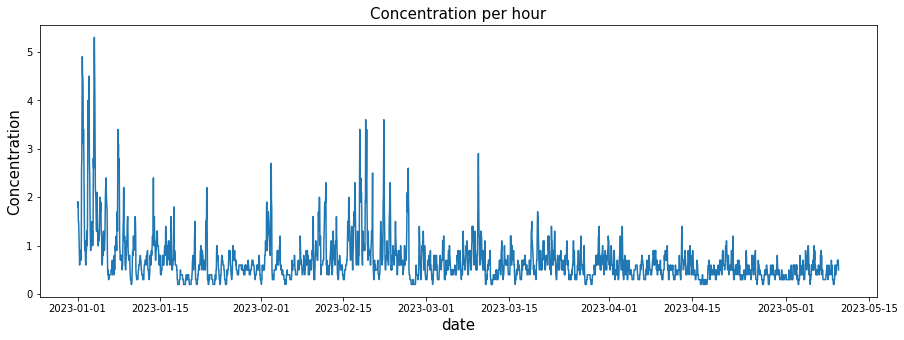

In [52]:
#plotting data concentration per hour lineplot
fig=plt.figure(figsize=(15,5))
sns.lineplot(data=data,x='DatetimeEnd',y='Concentration')
plt.title('Concentration per hour',fontsize=15)
plt.xlabel('date',fontsize=15)
plt.ylabel('Concentration',fontsize=15)
plt.show()

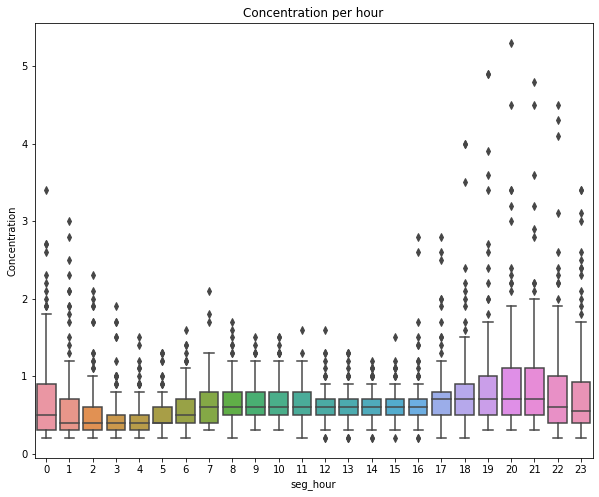

In [53]:
#Concentration per hour boxplot
fig, ax= plt.subplots(figsize= (10,8))
bp = sns.boxplot(data=data,x='seg_hour',y='Concentration')
ax.set_title("Concentration per hour")
plt.show()

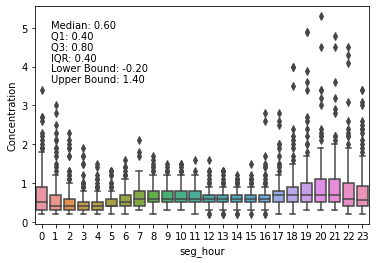

In [54]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a box plot using Seaborn
sns.boxplot(data=data, x='seg_hour',y='Concentration')

# Calculate the relevant statistics
median = data['Concentration'].median()
q1 = data['Concentration'].quantile(0.25)
q3 = data['Concentration'].quantile(0.75)
iqr = q3 - q1
lower_bound = q1 - (1.5 * iqr)
upper_bound = q3 + (1.5 * iqr)

# Add annotations to the plot
plt.text(0.05, 0.9, f'Median: {median:.2f}', transform=plt.gca().transAxes)
plt.text(0.05, 0.85, f'Q1: {q1:.2f}', transform=plt.gca().transAxes)
plt.text(0.05, 0.8, f'Q3: {q3:.2f}', transform=plt.gca().transAxes)
plt.text(0.05, 0.75, f'IQR: {iqr:.2f}', transform=plt.gca().transAxes)
plt.text(0.05, 0.7, f'Lower Bound: {lower_bound:.2f}', transform=plt.gca().transAxes)
plt.text(0.05, 0.65, f'Upper Bound: {upper_bound:.2f}', transform=plt.gca().transAxes)

# Show the plot
plt.show()


In [55]:
print("median",median)
print("q1",q1)
print("q3",q3)
print("iqr",iqr)
print("lower bound",lower_bound)
print("upper bound", upper_bound)

median 0.6
q1 0.4
q3 0.8
iqr 0.4
lower bound -0.20000000000000007
upper bound 1.4000000000000001


In [56]:
#Printing Outliers
outlier_pt=detect_outliers(data["Concentration"])
len(outlier_pt)

66

In [57]:
quantile1, quantile3= np.percentile(data['Concentration'],[25,75])
print(quantile1,quantile3)

0.4 0.8


In [58]:
## Find the IQR
iqr=quantile3-quantile1
print(iqr)

0.4


In [59]:
## Find the lower bound value and the higher bound value
lower_bound_val = quantile1 -(1.5 * iqr) 
upper_bound_val = quantile3 +(1.5 * iqr) 
print(lower_bound_val,upper_bound_val)

-0.20000000000000007 1.4000000000000001


In [60]:
data=data.loc[(data['Concentration']>=lower_bound_val)&(data['Concentration']<=upper_bound_val)]
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2904 entries, 5 to 3083
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype              
---  ------         --------------  -----              
 0   index          2904 non-null   int64              
 1   AirPollutant   2904 non-null   object             
 2   Concentration  2904 non-null   float64            
 3   DatetimeEnd    2904 non-null   datetime64[ns, UTC]
 4   seg_hour       2904 non-null   int64              
 5   day            2904 non-null   int64              
 6   month          2904 non-null   int64              
 7   weekday        2904 non-null   int64              
 8   year           2904 non-null   int64              
 9   weekend        2904 non-null   int64              
 10  day/night      2904 non-null   int64              
dtypes: datetime64[ns, UTC](1), float64(1), int64(8), object(1)
memory usage: 272.2+ KB


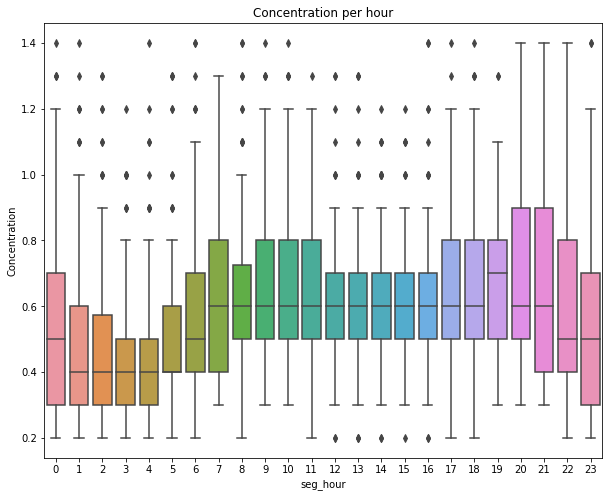

In [61]:
#Concentration per hour boxplot after removing outliesrs
fig, ax= plt.subplots(figsize= (10,8))
sns.boxplot(data=data,x='seg_hour',y='Concentration')
ax.set_title("Concentration per hour")
plt.show()

In [62]:
# Calculate the relevant statistics without outliers
median = data['Concentration'].median()
q1 = data['Concentration'].quantile(0.25)
q3 = data['Concentration'].quantile(0.75)
iqr = q3 - q1
lower_bound = q1 - (1.5 * iqr)
upper_bound = q3 + (1.5 * iqr)

In [63]:
print("median",median)
print("q1",q1)
print("q3",q3)
print("iqr",iqr)
print("lower bound",lower_bound)
print("upper bound", upper_bound)

median 0.5
q1 0.4
q3 0.7
iqr 0.29999999999999993
lower bound -0.04999999999999988
upper bound 1.15


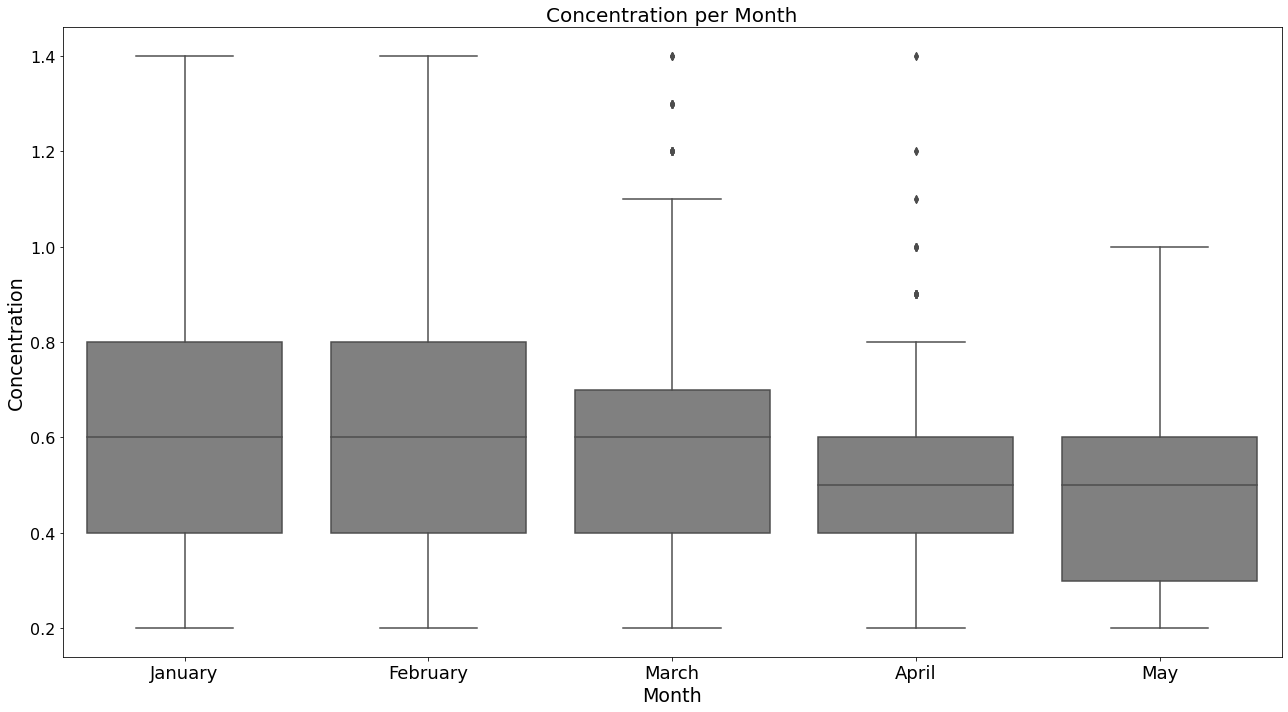

In [64]:
#Creating concentration each month boxplot after removing outliers
fig=plt.figure(figsize=(18,10))
sns.boxplot(data=data,x='month',y='Concentration',color='grey')
plt.title('Concentration per Month',fontsize=20)
plt.xlabel('Month',fontsize=19)
plt.xticks(np.arange(5),labels=['January','February','March','April','May'],fontsize=18)
plt.yticks(fontsize=16)
plt.ylabel('Concentration',fontsize=19)
plt.tight_layout()
plt.show()

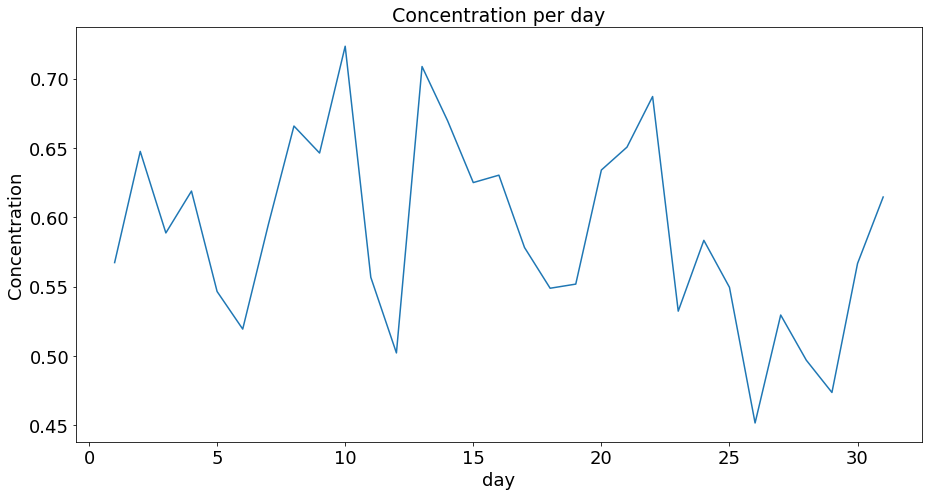

In [65]:
#Creating concentration during each day lineplot after removing outliesrs
fig=plt.figure(figsize=(13,7))
sns.lineplot(data=data,x='day',y='Concentration',ci=None)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.title('Concentration per day',fontsize=19)
plt.xlabel('day',fontsize=18)
plt.ylabel('Concentration',fontsize=18)
plt.tight_layout()
plt.show()

In [66]:
data.head()
data.reset_index(inplace=True)


In [67]:
#previous Hours, windows 2-3 (mean, min, max)
def prev_2hours():
   data['prev_2hours']=[data['Concentration'][i] if i==0 else data['Concentration'][i-1] if i==1 else data['Concentration'][i-2]
                                for i in range(len(data))]
prev_2hours()

def prev_two_hours_mean(): #mean of previous two hours (window = 2)
      data['prev_two_hours_mean']=data['index'].apply(lambda x: data['Concentration'].loc[x-2:x-1].mean()).round()
    
prev_two_hours_mean()
    
def prev_two_hours_min(): #minimum of  previous two on  hours (window = 2)
    data['prev_two_hours_min']=data['index'].apply(lambda x: data['Concentration'].loc[x-2:x-1].min())
prev_two_hours_min()
    
def prev_two_hours_max(): #maximum of previous two  hours (window = 2)
     data['prev_two_hours_max']=data['index'].apply(lambda x: data['Concentration'].loc[x-2:x-1].max())
        
prev_two_hours_max()
    
def prev_three_hours_mean(): #mean of previous three  hours (window = 3)
     data['prev_three_hours_mean']=data['index'].apply(lambda x: data['Concentration'].loc[x-3:x-1].mean()).round()
        
prev_three_hours_mean()
    
def prev_three_hours_min(): #minimum of previous three  hours (window = 3)
     data['prev_three_hours_min']=data['index'].apply(lambda x: data['Concentration'].loc[x-3:x-1].min())
        
prev_three_hours_min()
    
def prev_three_hours_max(): #maximum of previous three hours (window = 3)
     data['prev_three_hours_max']=data['index'].apply(lambda x: data['Concentration'].loc[x-3:x-1].max())
        
prev_three_hours_max()


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

In [27]:
data[['prev_2hours','Concentration']].head(10) #checking variable prev_2hours

,prev_2hours,Concentration
0,1.3,1.3
1,1.3,1.1
2,1.3,0.9
3,1.1,0.6
4,0.9,0.7
5,0.6,0.7
6,0.7,0.9
7,0.7,0.9
8,0.9,0.8
9,0.9,0.7


In [28]:
data[['prev_two_hours_max','prev_two_hours_min','prev_two_hours_mean','prev_2hours','Concentration']].head(25) #checking

,prev_two_hours_max,prev_two_hours_min,prev_two_hours_mean,prev_2hours,Concentration
0,0.7,0.6,1.0,1.3,1.3
1,0.7,0.7,1.0,1.3,1.1
2,0.9,0.7,1.0,1.3,0.9
3,0.9,0.9,1.0,1.1,0.6
4,0.9,0.8,1.0,0.9,0.7
5,0.8,0.7,1.0,0.6,0.7
6,1.1,0.7,1.0,0.7,0.9
7,1.2,1.1,1.0,0.7,0.9
8,1.2,0.9,1.0,0.9,0.8
9,1.1,0.9,1.0,0.9,0.7


In [68]:
#Train Test split
data=data.set_index("DatetimeEnd")
train=data.loc[data.index<"2023-04-15"]
test=data.loc[data.index>="2023-04-15"]

In [69]:
#hape of data train data and test data
print(data.shape)
print(train.shape)
print(test.shape)

(2904, 18)
(2306, 18)
(598, 18)


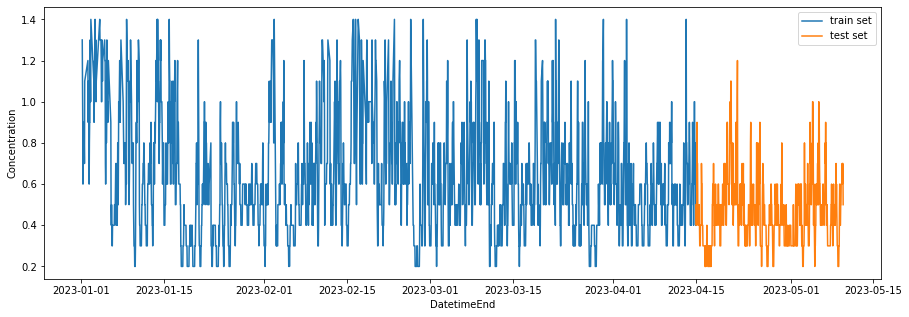

In [70]:
#Train test split Visualization
fig,ax=plt.subplots(figsize=(15,5))
sns.lineplot(data=train,x='DatetimeEnd',y='Concentration')
sns.lineplot(data=test,x='DatetimeEnd',y='Concentration')
ax.legend(['train set','test set'])
plt.show()

In [71]:
data.columns
data['Concentration']=data['Concentration'].round()
data['Concentration'].head()

DatetimeEnd
2023-01-01 05:00:00+00:00    1.0
2023-01-01 06:00:00+00:00    1.0
2023-01-01 07:00:00+00:00    1.0
2023-01-01 08:00:00+00:00    1.0
2023-01-01 09:00:00+00:00    1.0
Name: Concentration, dtype: float64

In [72]:
features=['seg_hour', 'day', 'month', 'weekday',
       'year','weekend', 'day/night',"prev_2hours",
       'prev_two_hours_mean', 'prev_two_hours_min', 'prev_two_hours_max',
       'prev_three_hours_mean', 'prev_three_hours_min',
       'prev_three_hours_max']

target="Concentration"

X_train=train[features]
y_train=train[target]
X_test=test[features]
y_test=test[target]

In [73]:
print(y_train)

DatetimeEnd
2023-01-01 05:00:00+00:00    1.3
2023-01-01 06:00:00+00:00    1.1
2023-01-01 07:00:00+00:00    0.9
2023-01-01 08:00:00+00:00    0.6
2023-01-01 09:00:00+00:00    0.7
                            ... 
2023-04-14 19:00:00+00:00    0.7
2023-04-14 20:00:00+00:00    0.6
2023-04-14 21:00:00+00:00    0.8
2023-04-14 22:00:00+00:00    0.8
2023-04-14 23:00:00+00:00    0.4
Name: Concentration, Length: 2306, dtype: float64


In [74]:
#Baseline model creation (Evaluation metrics: RMSE, MAE)
Baseline_pred=[data['Concentration'][i] if i==0 else data['Concentration'][i-1] if i==1 else data['Concentration'][i-2]
                                for i in range(len(data))]
data_base=data['Concentration']
rmse_base=np.sqrt(mean_squared_error(data_base,Baseline_pred))
mae_base=mean_absolute_error(data_base,Baseline_pred)
mape_base=mean_absolute_percentage_error(data_base,Baseline_pred)
print("RMSE_base:",rmse_base, "MAE_base:",mae_base,"MAPE_base",mape_base)

RMSE_base: 0.4654006834365961 MAE_base: 0.2165977961432507 MAPE_base 488510290158989.75


In [75]:
param_grid = {
    'n_estimators': [100, 500, 1000],
    'learning_rate': [0.001, 0.01, 0.1]
}
# Create the XGBoost regressor
model = xgb.XGBRegressor()

# Create the grid search object
grid_search = GridSearchCV(model, param_grid, cv=3, verbose=2)

In [76]:
# Fit the grid search to the training data
grid_search.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=100)

# Print the best parameters and best score
print("Best parameters: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[0]	validation_0-rmse:0.29080	validation_1-rmse:0.17085
[99]	validation_0-rmse:0.27466	validation_1-rmse:0.16481
[CV] END ..............learning_rate=0.001, n_estimators=100; total time=   0.3s
[0]	validation_0-rmse:0.29080	validation_1-rmse:0.17085
[99]	validation_0-rmse:0.27419	validation_1-rmse:0.16477
[CV] END ..............learning_rate=0.001, n_estimators=100; total time=   0.1s
[0]	validation_0-rmse:0.29078	validation_1-rmse:0.17083
[99]	validation_0-rmse:0.27330	validation_1-rmse:0.16243
[CV] END ..............learning_rate=0.001, n_estimators=100; total time=   0.2s
[0]	validation_0-rmse:0.29080	validation_1-rmse:0.17085
[100]	validation_0-rmse:0.27450	validation_1-rmse:0.16476
[200]	validation_0-rmse:0.26056	validation_1-rmse:0.15963
[300]	validation_0-rmse:0.24814	validation_1-rmse:0.15511
[400]	validation_0-rmse:0.23712	validation_1-rmse:0.15121
[499]	validation_0-rmse:0.22765	validation_1-rmse:0.14813
[CV] END ...

[CV] END ................learning_rate=0.1, n_estimators=100; total time=   0.2s
[0]	validation_0-rmse:0.27348	validation_1-rmse:0.16458
[99]	validation_0-rmse:0.13605	validation_1-rmse:0.15460
[CV] END ................learning_rate=0.1, n_estimators=100; total time=   0.2s
[0]	validation_0-rmse:0.27243	validation_1-rmse:0.16206
[99]	validation_0-rmse:0.12937	validation_1-rmse:0.16513
[CV] END ................learning_rate=0.1, n_estimators=100; total time=   0.2s
[0]	validation_0-rmse:0.27346	validation_1-rmse:0.16480
[100]	validation_0-rmse:0.14788	validation_1-rmse:0.16258
[200]	validation_0-rmse:0.14642	validation_1-rmse:0.17788
[300]	validation_0-rmse:0.14734	validation_1-rmse:0.18673
[400]	validation_0-rmse:0.14794	validation_1-rmse:0.18959
[499]	validation_0-rmse:0.14854	validation_1-rmse:0.19158
[CV] END ................learning_rate=0.1, n_estimators=500; total time=   1.2s
[0]	validation_0-rmse:0.27348	validation_1-rmse:0.16458
[100]	validation_0-rmse:0.13599	validation_1-rms

In [87]:
#Creating the model
model=xgb.XGBRegressor(n_estimators=500,learning_rate=0.01)
model.fit(X_train,y_train,eval_set=[(X_train,y_train),(X_test,y_test)],verbose=100)

[0]	validation_0-rmse:0.28906	validation_1-rmse:0.17012
[100]	validation_0-rmse:0.18284	validation_1-rmse:0.13770
[200]	validation_0-rmse:0.14994	validation_1-rmse:0.13899
[300]	validation_0-rmse:0.13389	validation_1-rmse:0.14255
[400]	validation_0-rmse:0.12414	validation_1-rmse:0.14470
[499]	validation_0-rmse:0.11646	validation_1-rmse:0.14525


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=500, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [78]:
x=data[['seg_hour', 'day', 'month', 'weekday',
       'year','weekend', 'day/night','prev_2hours',
       'prev_two_hours_mean', 'prev_two_hours_min', 'prev_two_hours_max',
       'prev_three_hours_mean', 'prev_three_hours_min',
       'prev_three_hours_max']]

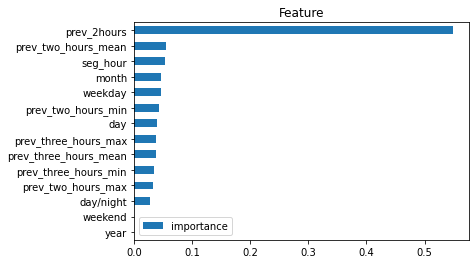

In [79]:
fi=pd.DataFrame(data=model.feature_importances_,index=x.columns,columns=['importance'])
fi.sort_values('importance').plot(kind='barh',title='Feature')
plt.show()

In [80]:
y_pred_train=model.predict(X_train).round()
y_pred_test=model.predict(X_test).round()

In [88]:
mae_train=mean_absolute_error(y_train,y_pred_train)
mae_train

0.32818733738074585

In [89]:
mae_test=mean_absolute_error(y_test,y_pred_test)
mae_test

0.4175585284280936

In [90]:
rmse_train=np.sqrt(mean_squared_error(y_train,y_pred_train))
rmse_train

0.359326246268748

In [91]:
rmse_test=np.sqrt(mean_squared_error(y_test,y_pred_test))
rmse_test

0.44208006357298635

In [92]:
data['Concentration'].describe()

count    2904.000000
mean        0.487603
std         0.499932
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000
Name: Concentration, dtype: float64

In [93]:
best=model

explainer = shap.TreeExplainer(best)

In [97]:
# Get SHAP values for a set of data points
shap_values = explainer.shap_values(x)

# Interpret the first data point using the SHAP values
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0], x.iloc[0, :])


In [46]:
# Fits the explainer
explainer = shap.Explainer(model.predict, X_test)
# Calculates the SHAP values - It takes some time
shap_values = explainer(X_test)


Permutation explainer: 599it [02:10,  4.19it/s]                         


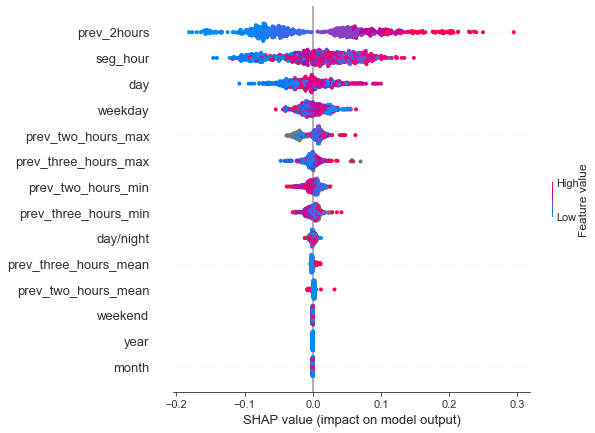

In [47]:
#Shap values Plot
sns.set_style("white")
shap.summary_plot(shap_values)

In [48]:
saved_model_path = '/Users/mariatsiompra/Documents/master/diplwmatiki/Forecasting/saved_model/co_model.sav'
os.makedirs(os.path.dirname(saved_model_path), exist_ok=True)
pickle.dump(model, open(saved_model_path, 'wb'))

In [ ]:
# Load saved model 

# loaded_model = pickle.load(open(saved_model_path, 'rb'))